In [2]:
import pandas as pd
import pandas_profiling as pf
from scipy.io.arff import loadarff
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, cross_val_predict

c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  


In [3]:
raw_data = loadarff('datasets/KDDTrain+.arff')
df = pd.DataFrame(raw_data[0])
pd.set_option('display.max_columns', None)
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,b'tcp',b'ftp_data',b'SF',491.0,0.0,b'0',0.0,0.0,0.0,0.0,b'0',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0',b'0',2.0,2.0,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150.0,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,b'normal'
1,0.0,b'udp',b'other',b'SF',146.0,0.0,b'0',0.0,0.0,0.0,0.0,b'0',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0',b'0',13.0,1.0,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255.0,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,b'normal'
2,0.0,b'tcp',b'private',b'S0',0.0,0.0,b'0',0.0,0.0,0.0,0.0,b'0',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0',b'0',123.0,6.0,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255.0,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,b'anomaly'
3,0.0,b'tcp',b'http',b'SF',232.0,8153.0,b'0',0.0,0.0,0.0,0.0,b'1',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0',b'0',5.0,5.0,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30.0,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,b'normal'
4,0.0,b'tcp',b'http',b'SF',199.0,420.0,b'0',0.0,0.0,0.0,0.0,b'1',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0',b'0',30.0,32.0,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255.0,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,b'normal'


# Exploratory

## Filtering data

In [4]:
toNumericCols = ['land', 'logged_in', 'is_host_login', 'is_guest_login']
df[toNumericCols] = df[toNumericCols].apply(pd.to_numeric, errors='coerce')

In [5]:
str_df = df.select_dtypes([object])
str_df = str_df.stack().str.decode('utf-8').unstack()
str_df.head()

,protocol_type,service,flag,class
0,tcp,ftp_data,SF,normal
1,udp,other,SF,normal
2,tcp,private,S0,anomaly
3,tcp,http,SF,normal
4,tcp,http,SF,normal


In [6]:
for column in str_df.columns: df[column] = str_df[column]
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,tcp,ftp_data,SF,491.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,2.0,2.0,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150.0,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0.0,udp,other,SF,146.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,13.0,1.0,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255.0,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,123.0,6.0,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255.0,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0.0,tcp,http,SF,232.0,8153.0,0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,5.0,5.0,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30.0,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0.0,tcp,http,SF,199.0,420.0,0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,30.0,32.0,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255.0,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [7]:
def checkAttack(value):
  if value == 'normal': return 0
  return 1

numeric_data = df.select_dtypes(include=np.number)
numeric_data["isAttack"] = str_df["class"].apply(checkAttack)
numeric_data.astype(np.number)
numeric_data.head()

c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,isAttack
0,0.0,491.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,2.0,2.0,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150.0,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0.0,146.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,13.0,1.0,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255.0,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,123.0,6.0,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255.0,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0.0,232.0,8153.0,0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,5.0,5.0,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30.0,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0.0,199.0,420.0,0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,30.0,32.0,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255.0,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


## Cuantitativas

In [8]:
numeric_data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,isAttack
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.0,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,0.001342,0.001103,0.302192,0.012669,0.000413,0.004096,0.0,0.000008,0.009423,84.107555,27.737888,0.284485,0.282485,0.119958,0.121183,0.660928,0.063053,0.097322,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240,0.465417
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,0.036603,0.045154,24.399618,0.483935,0.022181,0.099370,0.0,0.002817,0.096612,114.508607,72.635840,0.446456,0.447022,0.320436,0.323647,0.439623,0.180314,0.259830,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459,0.498805
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,1.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.0,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
allCorrelations = numeric_data.corr()['isAttack']
desiredCorr = allCorrelations[abs(allCorrelations) > 0.5]
desiredCorr

logged_in                  -0.690171
count                       0.576444
serror_rate                 0.650652
srv_serror_rate             0.648289
same_srv_rate              -0.751913
dst_host_srv_count         -0.722535
dst_host_same_srv_rate     -0.693803
dst_host_serror_rate        0.651842
dst_host_srv_serror_rate    0.654985
isAttack                    1.000000
Name: isAttack, dtype: float64

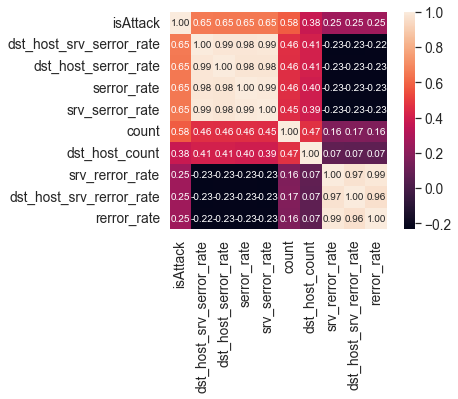

In [10]:
k = 10 #number of variables for heatmap
corrmat = numeric_data.corr()
cols = corrmat.nlargest(k, 'isAttack')['isAttack'].index
cm = np.corrcoef(numeric_data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

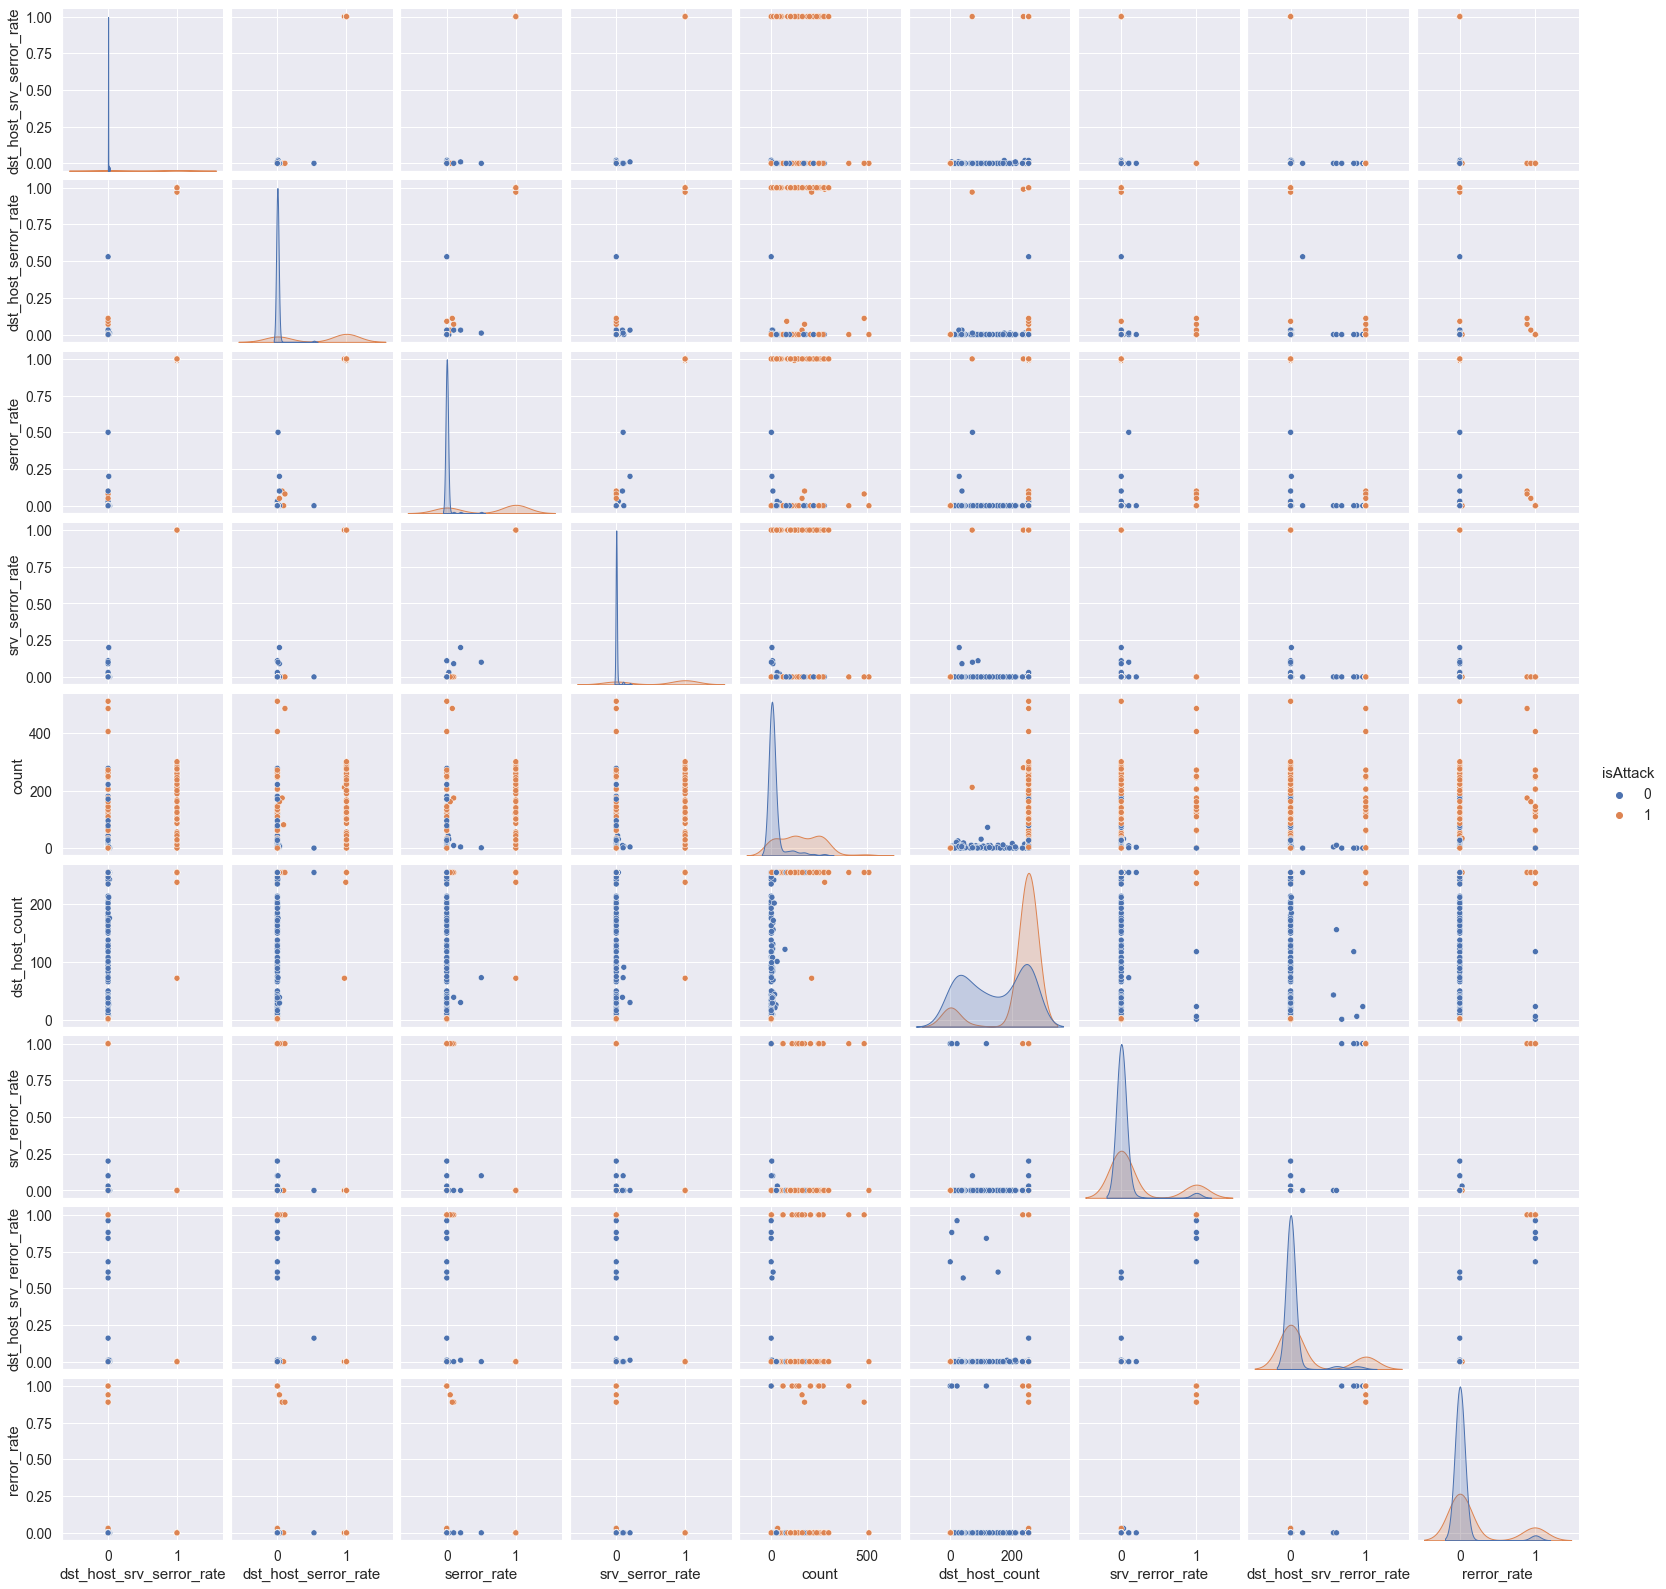

In [11]:
sns.pairplot(numeric_data[cols][0:250],hue="isAttack")

## Cuantitativas de interes

In [12]:
filtered_data = numeric_data[list(desiredCorr.index)[1:]]
filtered_data.head()

,count,serror_rate,srv_serror_rate,same_srv_rate,dst_host_srv_count,dst_host_same_srv_rate,dst_host_serror_rate,dst_host_srv_serror_rate,isAttack
0,2.0,0.0,0.0,1.00,25.0,0.17,0.00,0.00,0
1,13.0,0.0,0.0,0.08,1.0,0.00,0.00,0.00,0
2,123.0,1.0,1.0,0.05,26.0,0.10,1.00,1.00,1
3,5.0,0.2,0.2,1.00,255.0,1.00,0.03,0.01,0
4,30.0,0.0,0.0,1.00,255.0,1.00,0.00,0.00,0


count: Kurtosis: 2.0067893466227984 Skewness: 1.51425648765061 

serror_rate: Kurtosis: -1.0546098268185953 Skewness: 0.9631890428964239 

srv_serror_rate: Kurtosis: -1.044299959988806 Skewness: 0.9705856810983315 

same_srv_rate: Kurtosis: -1.609749542039288 Skewness: -0.5724926631603464 

dst_host_srv_count: Kurtosis: -1.7563128057623127 Skewness: 0.2837178091725708 

dst_host_same_srv_rate: Kurtosis: -1.8840187189033701 Skewness: -0.010447896247279353 

dst_host_serror_rate: Kurtosis: -1.0470016293720232 Skewness: 0.9659408137766112 

dst_host_srv_serror_rate: Kurtosis: -1.007999598605161 Skewness: 0.9917218217817211 

isAttack: Kurtosis: -1.9807724887371014 Skewness: 0.13866330178853242 



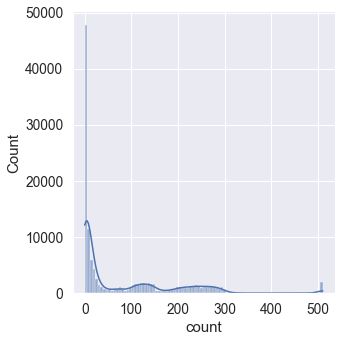

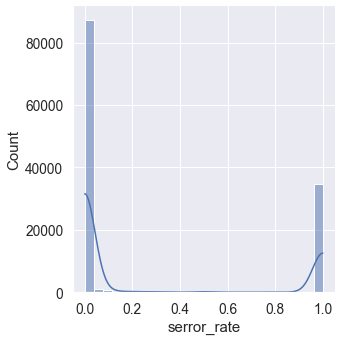

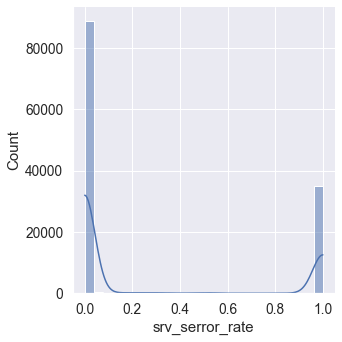

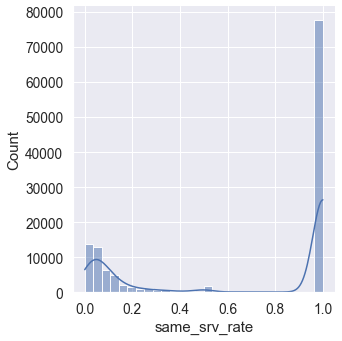

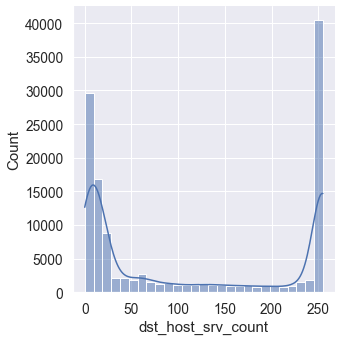

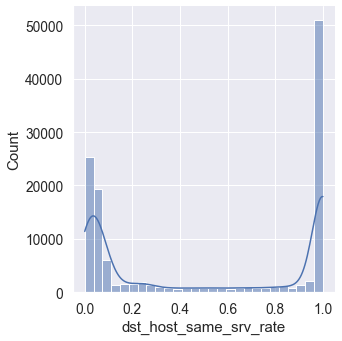

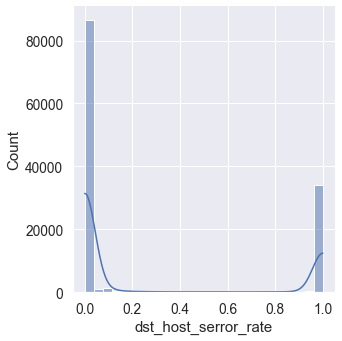

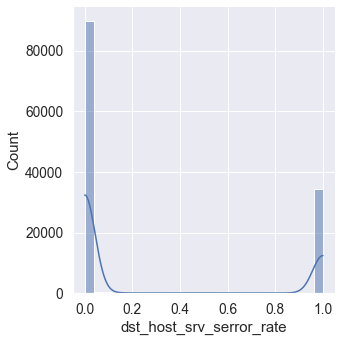

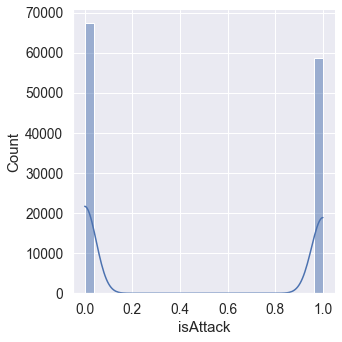

In [13]:
for var in filtered_data:
    data = numeric_data[var].dropna(how='all', axis=0)
    
    # Gráfico
    sns.displot(data, kde=True)

    # Mostrando normalidad
    print('\033[1m' + var + '\033[0m' + ': Kurtosis:', stats.kurtosis(data), 'Skewness:', stats.skew(data), '\n')

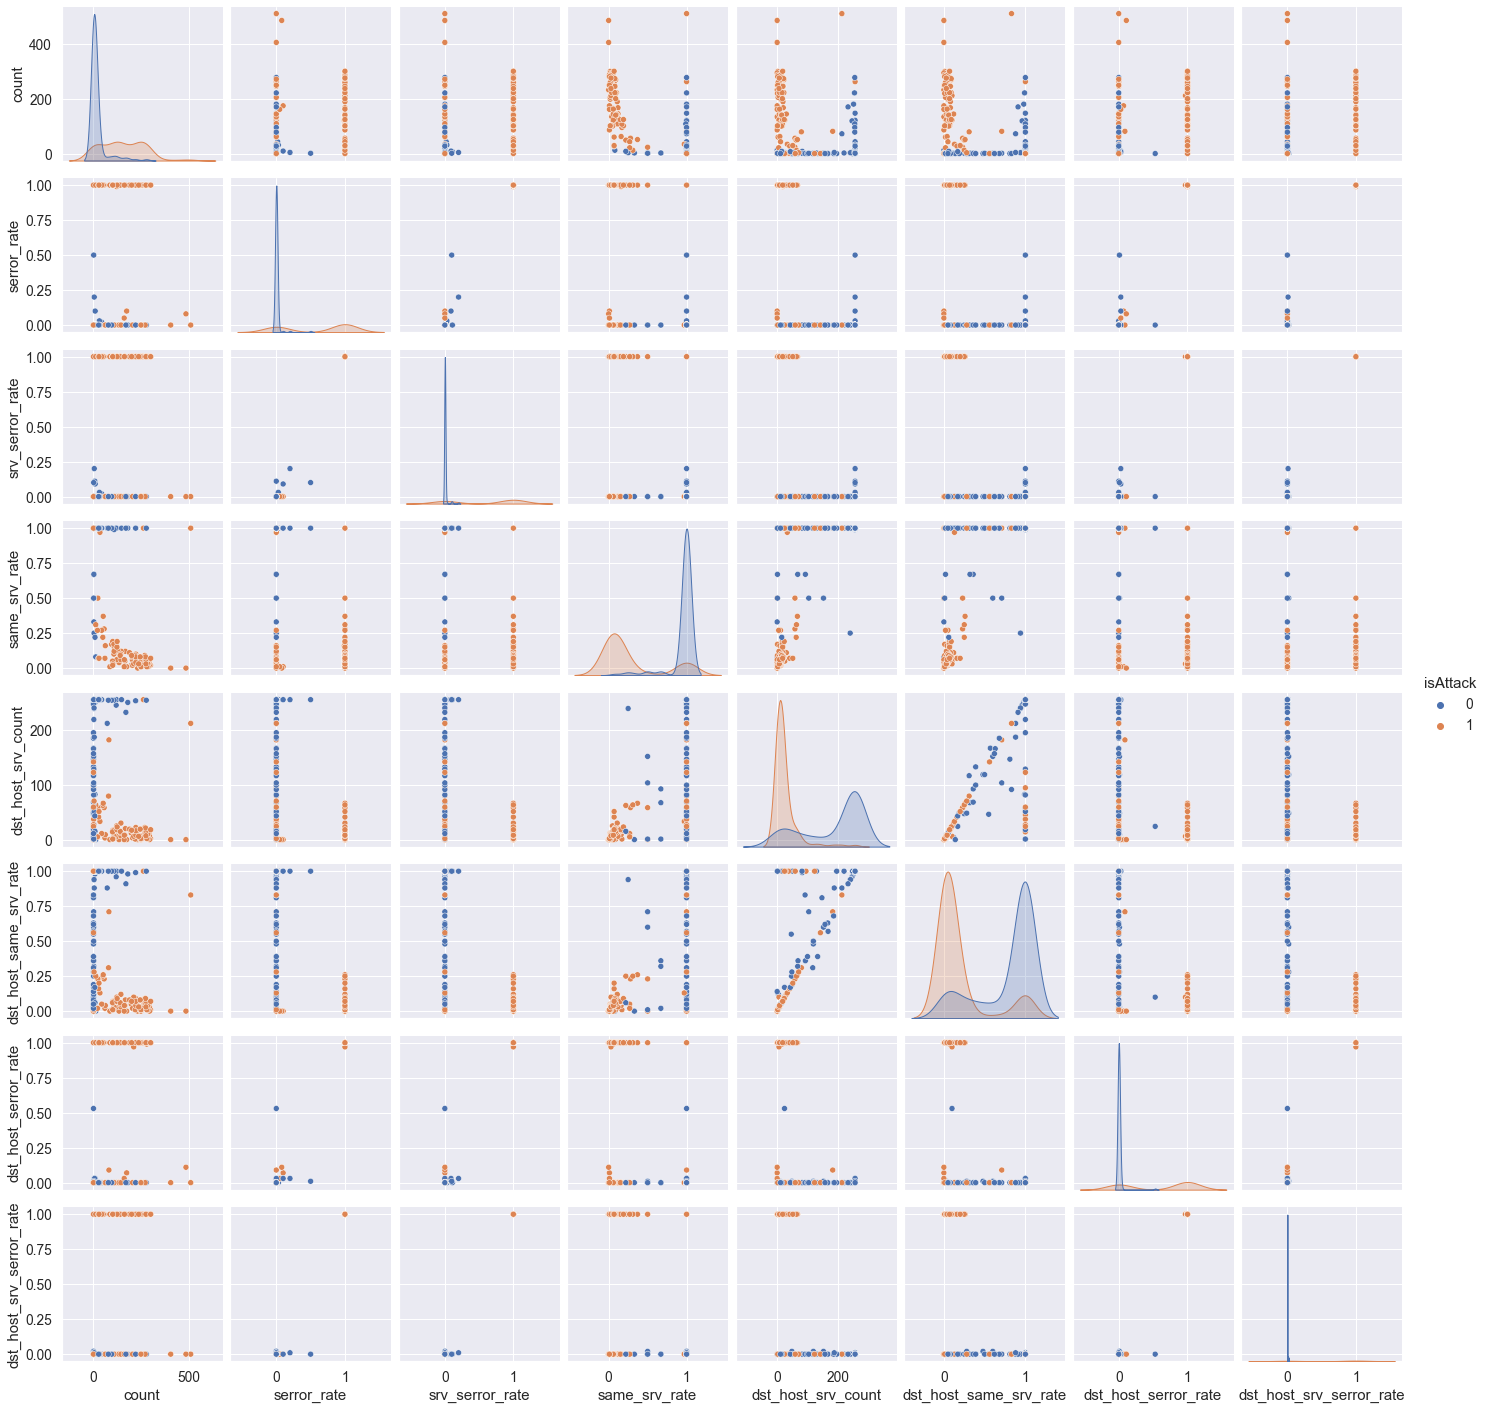

In [14]:
sns.pairplot(numeric_data[filtered_data.columns][0:250],hue="isAttack")

## Categoricas

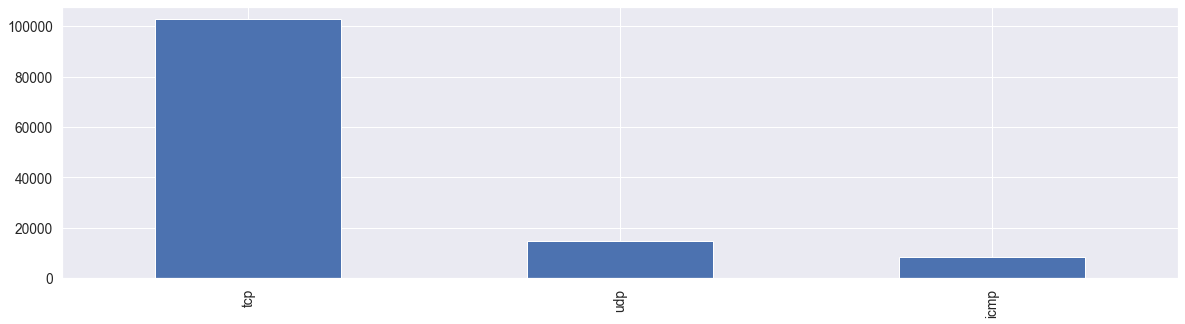

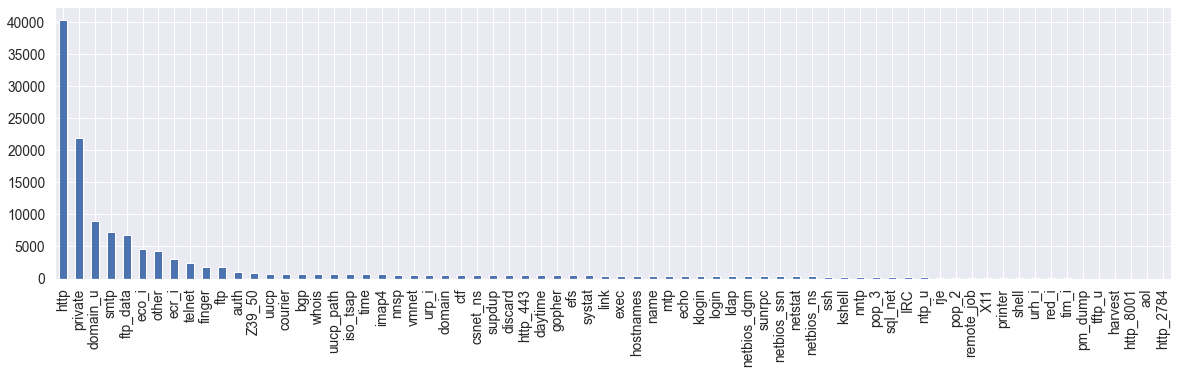

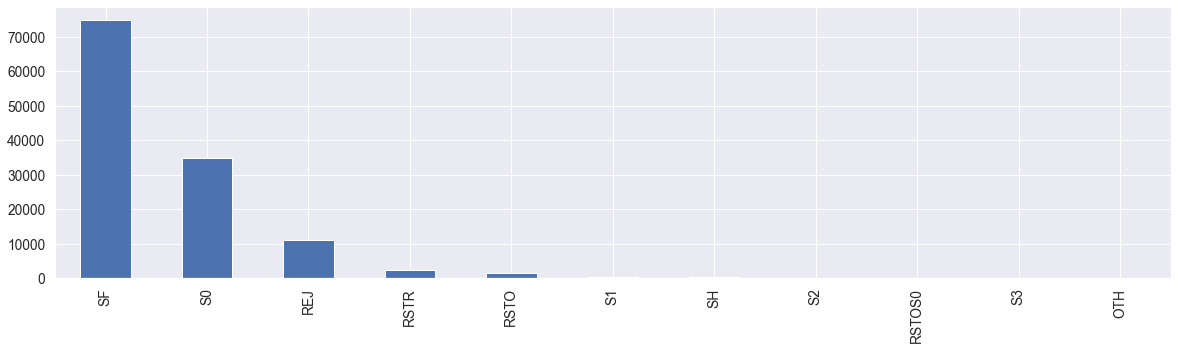

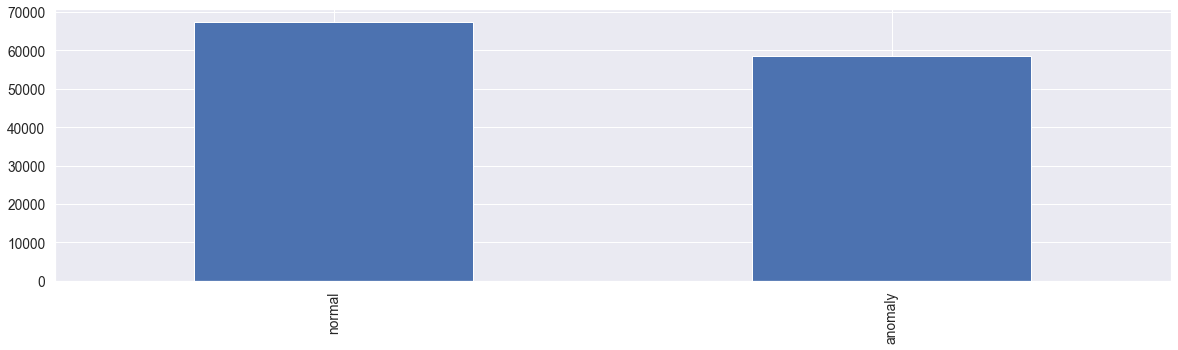

In [15]:
for var in str_df:
  plt.figure(figsize=(20,5))
  str_df[var].value_counts().plot(kind='bar')
  plt.show()

# Final data

In [16]:
final_data_1 = pd.concat([str_df, filtered_data], axis=1)
print('Number of columns:', len(final_data_1.columns))
final_data_1.head()

Number of columns: 13


,protocol_type,service,flag,class,count,serror_rate,srv_serror_rate,same_srv_rate,dst_host_srv_count,dst_host_same_srv_rate,dst_host_serror_rate,dst_host_srv_serror_rate,isAttack
0,tcp,ftp_data,SF,normal,2.0,0.0,0.0,1.00,25.0,0.17,0.00,0.00,0
1,udp,other,SF,normal,13.0,0.0,0.0,0.08,1.0,0.00,0.00,0.00,0
2,tcp,private,S0,anomaly,123.0,1.0,1.0,0.05,26.0,0.10,1.00,1.00,1
3,tcp,http,SF,normal,5.0,0.2,0.2,1.00,255.0,1.00,0.03,0.01,0
4,tcp,http,SF,normal,30.0,0.0,0.0,1.00,255.0,1.00,0.00,0.00,0


## Report

In [17]:
len(final_data_1[final_data_1['isAttack'] == 1])

58630

In [18]:
len(final_data_1[final_data_1['isAttack'] == 0])

67343

In [19]:
# rpt = pf.ProfileReport(df[0:100])
# rpt.to_file('./report.html')

In [20]:
str_df.columns

Index(['protocol_type', 'service', 'flag', 'class'], dtype='object')

# Modelos Dataset 1

In [21]:
def getTfidfVectorizer(row_name):
  dataBodyList = final_data_1[row_name].to_list()

  bv = TfidfVectorizer(min_df=0.05, max_df=0.95, use_idf=True, ngram_range=(1,5))
  bv_matrix = bv.fit_transform(dataBodyList)
  vocabulario = bv.get_feature_names()
  bv_matrix = bv_matrix.toarray()

  return pd.DataFrame(bv_matrix, columns=vocabulario)
df_protocol_type = getTfidfVectorizer('protocol_type')
df_service = getTfidfVectorizer('service')

c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [22]:
numeric_final_data = pd.concat([filtered_data, df_protocol_type, df_service], axis=1)
numeric_final_data.head()

,count,serror_rate,srv_serror_rate,same_srv_rate,dst_host_srv_count,dst_host_same_srv_rate,dst_host_serror_rate,dst_host_srv_serror_rate,isAttack,icmp,tcp,udp,domain_u,ftp_data,http,private,smtp
0,2.0,0.0,0.0,1.00,25.0,0.17,0.00,0.00,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,13.0,0.0,0.0,0.08,1.0,0.00,0.00,0.00,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,123.0,1.0,1.0,0.05,26.0,0.10,1.00,1.00,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,5.0,0.2,0.2,1.00,255.0,1.00,0.03,0.01,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,30.0,0.0,0.0,1.00,255.0,1.00,0.00,0.00,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


## K-NN

In [23]:
X = numeric_final_data.drop(['isAttack'], axis=1)
y = numeric_final_data['isAttack']

In [24]:
X.columns

Index(['count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate',
       'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'icmp', 'tcp', 'udp', 'domain_u',
       'ftp_data', 'http', 'private', 'smtp'],
      dtype='object')

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.218, random_state=1)


data_len = len(data)
print('Train:', round(len(X_train) / data_len, 2))
print('Val:', round(len(X_val) / data_len, 2))
print('Test:', len(X_test) / data_len)

Train: 0.55
Val: 0.15
Test: 0.3000007938208981


In [26]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

y_preds = model.predict(X_test)
y_preds_vals = model.predict(X_val)

In [27]:
result = confusion_matrix(y_test, y_preds)


print("TP: ", result[0][0])
print("FP: ", result[0][1])
print("FN: ", result[1][0])
print("TN: ", result[1][1])

TP:  19802
FP:  464
FN:  864
TN:  16662


In [28]:
print ('Accuracy:', accuracy_score(y_test, y_preds))
print ("Precision:", precision_score(y_test, y_preds))
print ("Recall: ", recall_score(y_test, y_preds))
print ("F1: ", f1_score(y_test, y_preds))

Accuracy: 0.9648602878916173
Precision: 0.9729066915800537
Recall:  0.9507018144471071
F1:  0.9616760937319635


In [29]:
print("------------ On val -------------")
print ('Accuracy:', accuracy_score(y_val, y_preds_vals))
print ("Precision:", precision_score(y_val, y_preds_vals))
print ("Recall: ", recall_score(y_val, y_preds_vals))
print ("F1: ", f1_score(y_val, y_preds_vals))

------------ On val -------------
Accuracy: 0.9640553474823138
Precision: 0.9715762273901809
Recall:  0.9517939687431213
F1:  0.961583365764163


### Validación Cruzada
Usaremos kfolds, vamos a usar 10.

In [30]:
cv_results = cross_validate(model,X, y, cv=10)
cv_results = pd.DataFrame(cv_results)
print("accuracy: ", cv_results['test_score'].mean())

accuracy:  0.9682154167420146


## Arboles de decision

In [31]:
arbol = DecisionTreeClassifier(max_depth=4, random_state=42) 
arbol = arbol.fit(X_train, y_train)
ay_pred = arbol.predict(X_test)
ay_pred_val = arbol.predict(X_val)

In [32]:
result_arbol = confusion_matrix(y_test, ay_pred)

print("TP: ", result_arbol[0][0])
print("FP: ", result_arbol[0][1])
print("FN: ", result_arbol[1][0])
print("TN: ", result_arbol[1][1])

result_arbol

TP:  19926
FP:  340
FN:  983
TN:  16543


array([[19926,   340],
       [  983, 16543]], dtype=int64)

In [33]:
result_arbol = confusion_matrix(y_val, ay_pred_val)
print("------------ On val -------------")
print("TP: ", result_arbol[0][0])
print("FP: ", result_arbol[0][1])
print("FN: ", result_arbol[1][0])
print("TN: ", result_arbol[1][1])

result_arbol

------------ On val -------------
TP:  9965
FP:  173
FN:  545
TN:  8541


array([[9965,  173],
       [ 545, 8541]], dtype=int64)

In [34]:
print ('Accuracy:', accuracy_score(y_test, ay_pred))
print ("Precision:", precision_score(y_test, ay_pred))
print ("Recall: ", recall_score(y_test, ay_pred))
print ("F1: ", f1_score(y_test, ay_pred))

Accuracy: 0.9649925910245555
Precision: 0.9798613990404549
Recall:  0.9439119023165583
F1:  0.9615507570693713


In [35]:
print("------------ On val -------------")
print ('Accuracy:', accuracy_score(y_val, ay_pred_val))
print ("Precision:", precision_score(y_val, ay_pred_val))
print ("Recall: ", recall_score(y_val, ay_pred_val))
print ("F1: ", f1_score(y_val, ay_pred_val))

------------ On val -------------
Accuracy: 0.9626508531002913
Precision: 0.9801468900619692
Recall:  0.9400176095091349
F1:  0.9596629213483145


### Validación Cruzada
Usaremos kfolds, vamos a usar 10.

In [36]:
cv_results = cross_validate(model,X, y, cv=10)
cv_results = pd.DataFrame(cv_results)
print("accuracy: ", cv_results['test_score'].mean())

accuracy:  0.9682154167420146


## SVM

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.218, random_state=1)


data_len = len(data)
print('Train:', round(len(X_train) / data_len, 2))
print('Val:', round(len(X_val) / data_len, 2))
print('Test:', len(X_test) / data_len)

Train: 0.55
Val: 0.15
Test: 0.3000007938208981


In [38]:
#Se transforman las colunas usando los preprocesadores
numeric_preprocessor = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

In [39]:
preprocesador = ColumnTransformer([('numerico', numeric_preprocessor, [0,-1])],remainder="passthrough")

### Mejor modelo SVM

In [40]:
model = make_pipeline(preprocesador, SVC(kernel="linear", C=32, degree=4))
model = model.fit(X_train, y_train)
svm_pred = model.predict(X_test)

In [41]:
svm_pred_val = model.predict(X_val)

In [42]:
result_svc = confusion_matrix(y_test, svm_pred)

print("TP: ", result_svc[0][0])
print("FP: ", result_svc[0][1])
print("FN: ", result_svc[1][0])
print("TN: ", result_svc[1][1])

result_svc

TP:  19437
FP:  829
FN:  1419
TN:  16107


array([[19437,   829],
       [ 1419, 16107]], dtype=int64)

In [43]:
result_svc = confusion_matrix(y_val, svm_pred_val)

print("------------ On val -------------")
print("TP: ", result_svc[0][0])
print("FP: ", result_svc[0][1])
print("FN: ", result_svc[1][0])
print("TN: ", result_svc[1][1])


result_svc

------------ On val -------------
TP:  9739
FP:  399
FN:  754
TN:  8332


array([[9739,  399],
       [ 754, 8332]], dtype=int64)

In [44]:
print ('Accuracy:', accuracy_score(y_test, svm_pred))
print ("Precision:", precision_score(y_test, svm_pred))
print ("Recall: ", recall_score(y_test, svm_pred))
print ("F1: ", f1_score(y_test, svm_pred))

Accuracy: 0.9405165114309907
Precision: 0.9510510155880963
Recall:  0.9190345771995891
F1:  0.934768730775927


In [45]:
print("------------ On val -------------")
print ('Accuracy:', accuracy_score(y_val, svm_pred_val))
print ("Precision:", precision_score(y_val, svm_pred_val))
print ("Recall: ", recall_score(y_val, svm_pred_val))
print ("F1: ", f1_score(y_val, svm_pred_val))

------------ On val -------------
Accuracy: 0.940022888056596
Precision: 0.9543007673805979
Recall:  0.9170151882016289
F1:  0.9352865241061907


### Validación Cruzada
Usaremos kfolds, vamos a usar 10.

In [46]:
cv_results = cross_validate(model,X, y, cv=10)
cv_results = pd.DataFrame(cv_results)
print("accuracy: ", cv_results['test_score'].mean())

## Analisis con Segundo Dataset

In [ ]:
import pandas as pd

csv_files = ['ml1.csv', 'ml2.csv']

df = pd.concat([pd.read_csv('datasets/dataset_phase2/'+file) for file in csv_files ], ignore_index=True)

# remove special character
df.columns = df.columns.str.replace(' ', '')

In [ ]:
import numpy as np

df["isAttack"] = df["Label"].apply(lambda x: 0 if x == 'BENIGN' else 1)
df = df.select_dtypes(include=np.number)
df.astype(np.number)

In [ ]:
allCorrelations = df.corr()['isAttack']
desiredCorr = allCorrelations[abs(allCorrelations) > 0.4]
desiredCorr

In [ ]:
import seaborn as sns

k = 10 #number of variables for heatmap
corrmat = df.corr()
cols = corrmat.nlargest(k, 'isAttack')['isAttack'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

In [ ]:
filtered_data = df[list(desiredCorr.index)]
filtered_data.head()

In [ ]:
sns.pairplot(df[filtered_data.columns][0:250], hue="isAttack")

In [ ]:
for var in filtered_data:
    data = df[var].dropna(how='all', axis=0)
    
    # Gráfico
    sns.displot(data, kde=True)

    # Mostrando normalidad
    print('\033[1m' + var + '\033[0m' + ': Kurtosis:', stats.kurtosis(data), 'Skewness:', stats.skew(data), '\n')

In [ ]:
# rpt = pf.ProfileReport(df[0:100])
# rpt.to_file('./report2.html')